# Proyek Q-Learning pada Environment CartPole-v1

Pada notebook ini, kita akan membangun, melatih, menganalisis, dan menguji agen Q-Learning yang diperkuat dengan berbagai optimasi pada environment `CartPole-v1` dari Gymnasium.

## Struktur Notebook:
1. Inisialisasi Library & Kelas Agen
2. Pelatihan Agen Q-Learning
3. Analisis Q-Table Hasil Pembelajaran
4. Pengujian Kinerja Agen
5. Visualisasi Proses dan Hasil Latihan
6. Penyimpanan Model

In [16]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle


        Initialize Q-Learning Agent with optimized parameters
        
        Args:
            env: Gymnasium environment
            n_bins: Number of bins for discretizing each state dimension
            alpha: Learning rate (higher for faster learning)
            gamma: Discount factor
            epsilon: Initial exploration rate
            min_epsilon: Minimum exploration rate
            epsilon_decay: Decay rate for epsilon

ENHANCED Q-LEARNING AGENT FOR CARTPOLE-V1
Environment Info:
- State Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
- Action Space: Discrete(2)
- Max Episode Steps: 500
Training Q-Learning agent for 2000 episodes...
Episode 200: Avg Reward = 24.51, Last Episode = 47, Epsilon = 0.819, Q-states = 219, Consecutive Good = 0
Episode 400: Avg Reward = 34.42, Last Episode = 35, Epsilon = 0.670, Q-states = 291, Consecutive Good = 0
Episode 600: Avg Reward = 56.41, Last Episode = 19, Epsilon = 0.594, Q-states = 490, Consecutive Good = 0
Episode 800: Avg Reward = 69.32, Last Episode = 90, Epsilon = 0.571, Q-states = 671, Consecutive Good = 0
Episode 1000: Avg Reward = 80.81, Last Episode = 29, Epsilon = 0.549, Q-states = 825, Consecutive Good = 0
Episode 1200: Avg Reward = 78.10, Last Episode = 13, Epsilon = 0.527, Q-states = 921, Consecutive Good = 0
Episode 1400: Avg Reward = 89.60, Last Episode = 208, Epsilon = 0.506,

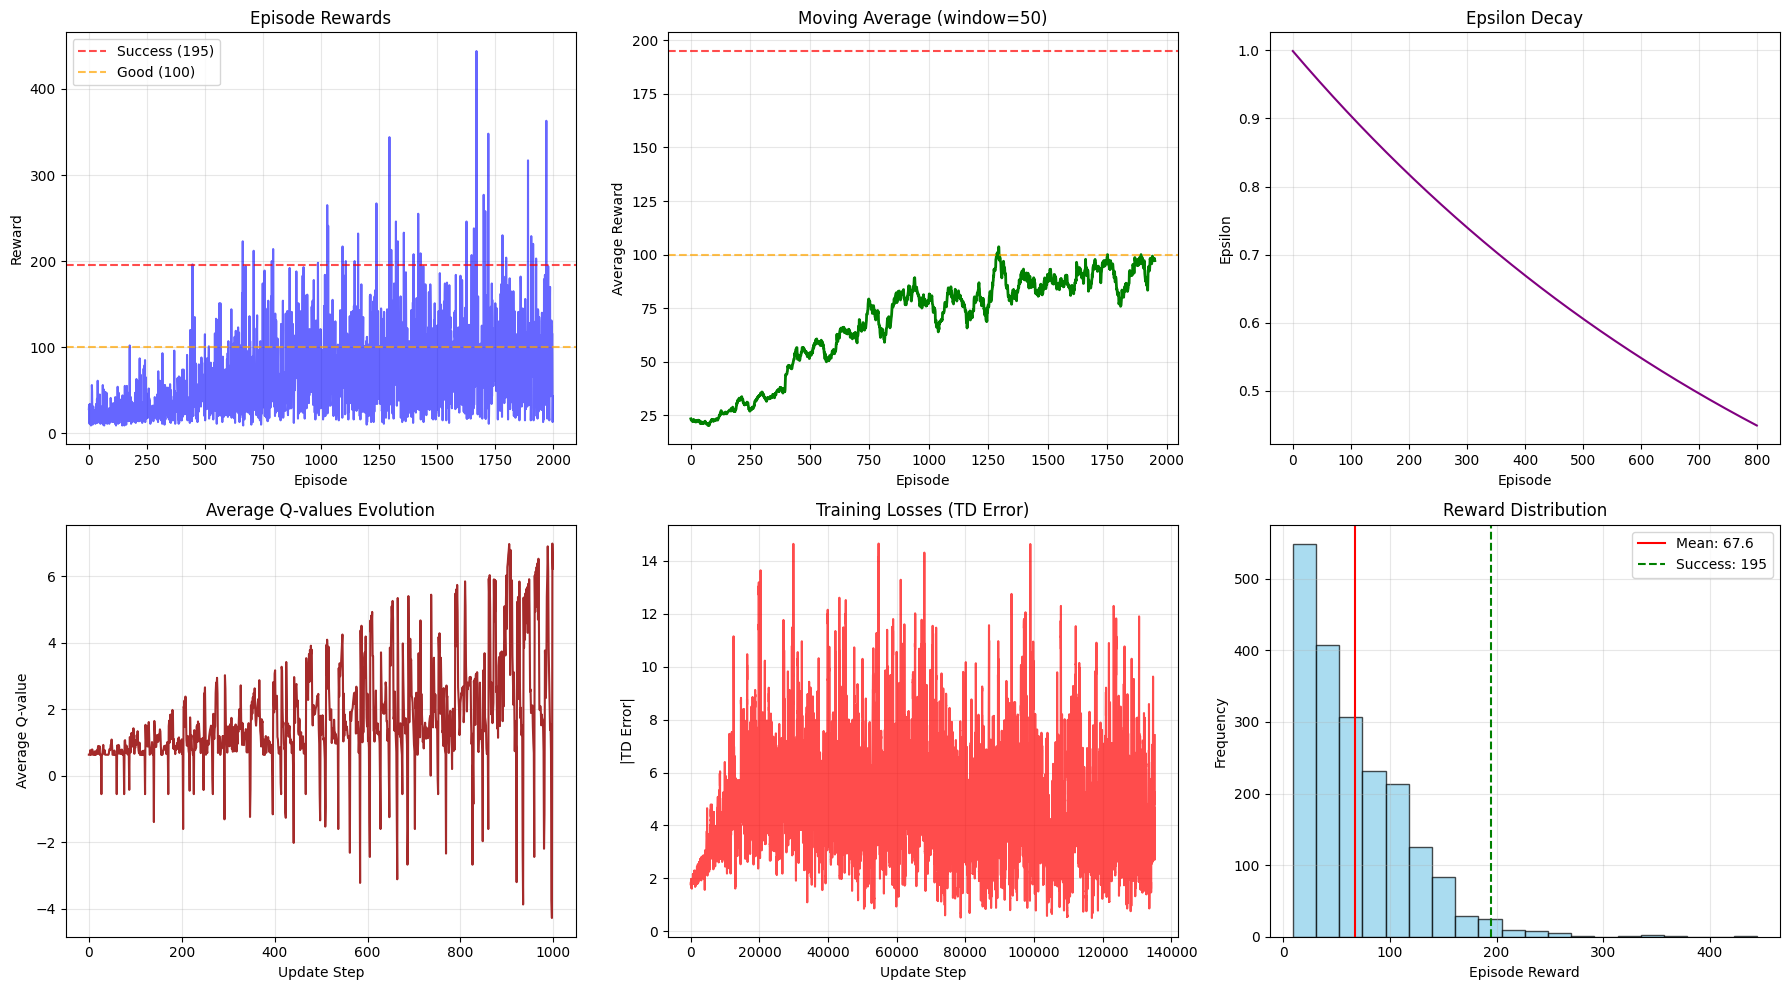

Enhanced model saved to cartpole_qlearning_final.pkl


In [15]:

class QLearningAgent:
    
    def __init__(self, env, n_bins=(6, 6, 12, 12), alpha=0.2, gamma=0.99, 
                 epsilon=1.0, min_epsilon=0.01, epsilon_decay=0.999):
    
        self.env = env
        self.n_bins = n_bins
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        
        # Create bins for state discretization
        self.bins = self._create_bins()
        
        # Initialize Q-table with optimistic values
        self.Q = defaultdict(lambda: np.ones(env.action_space.n) * 0.5)
        
        # Tracking variables
        self.episode_rewards = []
        self.episode_lengths = []
        self.training_losses = []
        self.epsilon_history = []
        self.q_values_history = []
        
    def _create_bins(self):
        # Focus on critical ranges where CartPole behavior matters most
        bins = [
            np.linspace(-2.0, 2.0, self.n_bins[0]),      # Cart position (critical range)
            np.linspace(-2.0, 2.0, self.n_bins[1]),      # Cart velocity
            np.linspace(-0.2, 0.2, self.n_bins[2]),      # Pole angle (most critical)
            np.linspace(-2.0, 2.0, self.n_bins[3])       # Pole angular velocity
        ]
        return bins
    
    def discretize_state(self, state):
        state_idx = []
        for i, val in enumerate(state):
            # Clip to bin boundaries
            clipped_val = np.clip(val, self.bins[i][0], self.bins[i][-1])
            # Find bin index
            idx = np.digitize(clipped_val, self.bins[i]) - 1
            # Ensure valid range
            idx = np.clip(idx, 0, self.n_bins[i] - 1)
            state_idx.append(idx)
        return tuple(state_idx)
    
    def choose_action(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = self.Q[state]
            # Add small random noise for tie-breaking
            q_values_noisy = q_values + np.random.normal(0, 1e-8, len(q_values))
            return np.argmax(q_values_noisy)
    
    def update_q_value(self, state, action, reward, next_state, done):
        # Custom reward function for CartPole
        shaped_reward = self._shape_reward(state, action, reward, done)
        
        current_q = self.Q[state][action]
        
        if done:
            target_q = shaped_reward
        else:
            # Double Q-Learning inspired update (more stable)
            next_q_values = self.Q[next_state]
            target_q = shaped_reward + self.gamma * np.max(next_q_values)
        
        # Adaptive learning rate based on TD error
        td_error = target_q - current_q
        adaptive_alpha = self.alpha * min(1.0, abs(td_error) + 0.1)
        
        # Update Q-value
        self.Q[state][action] += adaptive_alpha * td_error
        
        # Track statistics
        self.training_losses.append(abs(td_error))
        
        # Track Q-values for analysis
        if len(self.q_values_history) < 1000:
            self.q_values_history.append(np.mean(self.Q[state]))
    
    def _shape_reward(self, state, action, reward, done):
        if done and reward == 1.0:
            # Episode ended early (failure) - heavy penalty
            return -10.0
        
        # Convert discrete state back to approximate continuous values
        cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_vel_idx = state
        
        # Approximate continuous values from bin indices
        cart_pos = self.bins[0][min(cart_pos_idx, len(self.bins[0])-1)]
        pole_angle = self.bins[2][min(pole_angle_idx, len(self.bins[2])-1)]
        
        # Reward shaping components
        position_reward = 1.0 - abs(cart_pos) / 2.0  # Penalty for being far from center
        angle_reward = 1.0 - abs(pole_angle) / 0.2   # Penalty for large pole angle
        stability_reward = 2.0  # Base reward for staying upright
        
        # Combine rewards
        shaped_reward = reward + 0.1 * (position_reward + angle_reward + stability_reward)
        
        return shaped_reward
    
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)
    
    def train(self, episodes=1000, verbose=True):
        print(f"Training Q-Learning agent for {episodes} episodes...")
        
        # Track best performance for model selection
        best_avg_reward = -float('inf')
        best_q_table = None
        
        consecutive_good_episodes = 0
        target_consecutive = 10  # Need 10 consecutive good episodes
        
        for episode in range(episodes):
            state, info = self.env.reset()
            state = self.discretize_state(state)
            
            episode_reward = 0
            episode_length = 0
            terminated = False
            truncated = False
            
            while not terminated and not truncated:
                action = self.choose_action(state, training=True)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                next_state = self.discretize_state(next_state)
                
                done = terminated or truncated
                self.update_q_value(state, action, reward, next_state, done)
                
                episode_reward += reward
                episode_length += 1
                state = next_state
            
            # Store episode data
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            
            # Decay epsilon more aggressively early on
            if episode < 500:
                self.decay_epsilon()
            elif episode % 5 == 0:  # Slower decay later
                self.decay_epsilon()
            
            # Check for improvement
            if episode >= 100:
                recent_avg = np.mean(self.episode_rewards[-100:])
                
                # Track consecutive good episodes
                if episode_reward >= 100:  # Good episode threshold
                    consecutive_good_episodes += 1
                else:
                    consecutive_good_episodes = 0
                
                # Save best model
                if recent_avg > best_avg_reward:
                    best_avg_reward = recent_avg
                    best_q_table = dict(self.Q)
                
                # Early stopping criteria
                if recent_avg >= 200:
                    print(f"\nTarget performance reached at episode {episode + 1}!")
                    break
                
                if consecutive_good_episodes >= target_consecutive and recent_avg >= 150:
                    print(f"\nStable good performance achieved at episode {episode + 1}!")
                    break
            
            # Progress reporting
            if verbose and (episode + 1) % 200 == 0:
                recent_avg = np.mean(self.episode_rewards[-100:]) if episode >= 99 else np.mean(self.episode_rewards)
                print(f"Episode {episode + 1}: Avg Reward = {recent_avg:.2f}, "
                      f"Last Episode = {episode_reward:.0f}, Epsilon = {self.epsilon:.3f}, "
                      f"Q-states = {len(self.Q)}, Consecutive Good = {consecutive_good_episodes}")
        
        # Restore best model if it was better
        if best_q_table is not None and best_avg_reward > np.mean(self.episode_rewards[-100:]):
            print(f"Restoring best model with avg reward: {best_avg_reward:.2f}")
            self.Q = defaultdict(lambda: np.ones(self.env.action_space.n) * 0.5)
            self.Q.update(best_q_table)
        
        print(f"Training completed. Final Q-table size: {len(self.Q)} states")
    
    def test(self, episodes=100, render=False):
        print(f"Testing agent for {episodes} episodes...")
        
        test_rewards = []
        test_lengths = []
        
        for episode in range(episodes):
            state, info = self.env.reset()
            state = self.discretize_state(state)
            
            episode_reward = 0
            episode_length = 0
            terminated = False
            truncated = False
            
            while not terminated and not truncated:
                action = self.choose_action(state, training=False)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                
                if render:
                    self.env.render()
                
                next_state = self.discretize_state(next_state)
                episode_reward += reward
                episode_length += 1
                state = next_state
            
            test_rewards.append(episode_reward)
            test_lengths.append(episode_length)
        
        stats = {
            'mean_reward': np.mean(test_rewards),
            'std_reward': np.std(test_rewards),
            'mean_length': np.mean(test_lengths),
            'std_length': np.std(test_lengths),
            'success_rate': np.mean([r >= 195 for r in test_rewards]),
            'good_rate': np.mean([r >= 100 for r in test_rewards]),  # Additional metric
            'max_reward': np.max(test_rewards),
            'min_reward': np.min(test_rewards)
        }
        
        return stats
    
    def plot_training_progress(self):
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        # Episode rewards with success threshold
        axes[0, 0].plot(self.episode_rewards, alpha=0.6, color='blue')
        axes[0, 0].axhline(y=195, color='red', linestyle='--', alpha=0.7, label='Success (195)')
        axes[0, 0].axhline(y=100, color='orange', linestyle='--', alpha=0.7, label='Good (100)')
        axes[0, 0].set_title('Episode Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Moving average
        if len(self.episode_rewards) >= 50:
            window = min(50, len(self.episode_rewards) // 4)
            moving_avg = np.convolve(self.episode_rewards, np.ones(window)/window, mode='valid')
            axes[0, 1].plot(moving_avg, color='green', linewidth=2)
            axes[0, 1].axhline(y=195, color='red', linestyle='--', alpha=0.7)
            axes[0, 1].axhline(y=100, color='orange', linestyle='--', alpha=0.7)
            axes[0, 1].set_title(f'Moving Average (window={window})')
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].set_ylabel('Average Reward')
            axes[0, 1].grid(True, alpha=0.3)
        
        # Epsilon decay
        if self.epsilon_history:
            axes[0, 2].plot(self.epsilon_history, color='purple')
            axes[0, 2].set_title('Epsilon Decay')
            axes[0, 2].set_xlabel('Episode')
            axes[0, 2].set_ylabel('Epsilon')
            axes[0, 2].grid(True, alpha=0.3)
        
        # Q-values evolution
        if self.q_values_history:
            axes[1, 0].plot(self.q_values_history, color='brown')
            axes[1, 0].set_title('Average Q-values Evolution')
            axes[1, 0].set_xlabel('Update Step')
            axes[1, 0].set_ylabel('Average Q-value')
            axes[1, 0].grid(True, alpha=0.3)
        
        # Training losses (smoothed)
        if len(self.training_losses) > 100:
            window = min(100, len(self.training_losses) // 10)
            smoothed_losses = np.convolve(self.training_losses, np.ones(window)/window, mode='valid')
            axes[1, 1].plot(smoothed_losses, color='red', alpha=0.7)
            axes[1, 1].set_title('Training Losses (TD Error)')
            axes[1, 1].set_xlabel('Update Step')
            axes[1, 1].set_ylabel('|TD Error|')
            axes[1, 1].grid(True, alpha=0.3)
        
        # Performance distribution
        if len(self.episode_rewards) > 0:
            axes[1, 2].hist(self.episode_rewards, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            axes[1, 2].axvline(x=np.mean(self.episode_rewards), color='red', linestyle='-', 
                              label=f'Mean: {np.mean(self.episode_rewards):.1f}')
            axes[1, 2].axvline(x=195, color='green', linestyle='--', label='Success: 195')
            axes[1, 2].set_title('Reward Distribution')
            axes[1, 2].set_xlabel('Episode Reward')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filename='qlearning_cartpole_enhanced.pkl'):
        model_data = {
            'Q': dict(self.Q),
            'bins': self.bins,
            'n_bins': self.n_bins,
            'hyperparameters': {
                'alpha': self.alpha,
                'gamma': self.gamma,
                'epsilon': self.epsilon,
                'min_epsilon': self.min_epsilon,
                'epsilon_decay': self.epsilon_decay
            },
            'training_history': {
                'episode_rewards': self.episode_rewards,
                'episode_lengths': self.episode_lengths,
                'epsilon_history': self.epsilon_history
            }
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Enhanced model saved to {filename}")
    
    def analyze_q_table(self):
        if not self.Q:
            print("Q-table is empty!")
            return
        
        print("\n" + "="*50)
        print("Q-TABLE ANALYSIS")
        print("="*50)
        
        # Basic statistics
        all_q_values = []
        for state_actions in self.Q.values():
            all_q_values.extend(state_actions)
        
        print(f"Total states explored: {len(self.Q)}")
        print(f"Average Q-value: {np.mean(all_q_values):.3f}")
        print(f"Max Q-value: {np.max(all_q_values):.3f}")
        print(f"Min Q-value: {np.min(all_q_values):.3f}")
        print(f"Q-value std: {np.std(all_q_values):.3f}")
        
        # Action preference analysis
        action_preferences = []
        for state_actions in self.Q.values():
            action_preferences.append(np.argmax(state_actions))
        
        action_0_count = action_preferences.count(0)
        action_1_count = action_preferences.count(1)
        
        print(f"\nAction preferences:")
        print(f"- Action 0 (Left): {action_0_count} states ({action_0_count/len(self.Q)*100:.1f}%)")
        print(f"- Action 1 (Right): {action_1_count} states ({action_1_count/len(self.Q)*100:.1f}%)")
        
        print("="*50)


def main():
    
    # Create environment
    env = gym.make('CartPole-v1')
    
    print("="*70)
    print("ENHANCED Q-LEARNING AGENT FOR CARTPOLE-V1")
    print("="*70)
    print("Environment Info:")
    print(f"- State Space: {env.observation_space}")
    print(f"- Action Space: {env.action_space}")
    print(f"- Max Episode Steps: {env.spec.max_episode_steps}")
    print("="*70)
    
    # Create agent with carefully tuned hyperparameters
    agent = QLearningAgent(
        env=env,
        n_bins=(6, 6, 12, 12),   # Focused discretization
        alpha=0.2,               # Higher learning rate
        gamma=0.99,              # Standard discount
        epsilon=1.0,             # Full exploration initially
        min_epsilon=0.01,        # Small final exploration
        epsilon_decay=0.999      # Slower decay
    )
    
    # Train the agent
    agent.train(episodes=2000, verbose=True)
    
    # Analyze the learned policy
    agent.analyze_q_table()
    
    # Test the agent
    print("\n" + "="*70)
    print("TESTING PHASE")
    print("="*70)
    test_stats = agent.test(episodes=100)
    
    # Comprehensive results
    print("\n" + "="*70)
    print("FINAL RESULTS:")
    print("="*70)
    print(f"Average Reward: {test_stats['mean_reward']:.2f} ± {test_stats['std_reward']:.2f}")
    print(f"Average Length: {test_stats['mean_length']:.2f} ± {test_stats['std_length']:.2f}")
    print(f"Success Rate: {test_stats['success_rate']:.1%} (Episodes ≥ 195)")
    print(f"Good Performance Rate: {test_stats['good_rate']:.1%} (Episodes ≥ 100)")
    print(f"Best Episode: {test_stats['max_reward']:.0f} steps")
    print(f"Worst Episode: {test_stats['min_reward']:.0f} steps")
    print(f"Q-table size: {len(agent.Q)} states")
    print(f"Total training episodes: {len(agent.episode_rewards)}")
    
    # Performance classification
    mean_reward = test_stats['mean_reward']
    if mean_reward >= 195:
        print("🎉 EXCELLENT: Agent has mastered CartPole!")
        grade = "A+"
    elif mean_reward >= 150:
        print("🟢 VERY GOOD: Strong performance, minor improvements possible")
        grade = "A"
    elif mean_reward >= 100:
        print("🟡 GOOD: Decent performance, room for improvement")
        grade = "B"
    elif mean_reward >= 50:
        print("🟠 FAIR: Some learning occurred, needs more training")
        grade = "C"
    else:
        print("🔴 POOR: Minimal learning, major issues need addressing")
        grade = "D"
    
    print(f"Performance Grade: {grade}")
    
    # Training efficiency analysis
    if len(agent.episode_rewards) > 100:
        final_100_avg = np.mean(agent.episode_rewards[-100:])
        first_100_avg = np.mean(agent.episode_rewards[:100])
        improvement = final_100_avg - first_100_avg
        print(f"Learning Progress: {improvement:.1f} point improvement")
    
    print("="*70)
    
    # Show training progress
    agent.plot_training_progress()
    
    # Save the model
    agent.save_model('cartpole_qlearning_final.pkl')
    
    # Cleanup
    env.close()
    
    return agent, test_stats


if __name__ == "__main__":
    main()